In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import glob
import os
import string
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralCoclustering
import itertools
import matplotlib
import calpgs
from admix.data import pval2chisq, zsc2pval
from utils import load_r2_result, plot_heatmap2

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
DATA_URL = "./data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}
df_display = pd.read_excel(DATA_URL, sheet_name=2)

In [3]:
# PREFIX = "OLD-0804"
PREFIX = ""

In [4]:
def plot_wrapper(group, trait_list, cbar_pad=0.04, cbar_fraction=0.0188):
    df_baseline, df_diff, df_diff_pval, df_diff_zscore = load_r2_result(
        result_dir=f"out/{PREFIX}/", group=group
    )
    df_diff_plot = df_diff.loc[covar_map.keys(), trait_list]
    # p-value is converted from z-score
    df_pval_plot = df_diff_zscore.loc[covar_map.keys(), trait_list].applymap(zsc2pval)
    df_annot = pd.DataFrame("", index=df_diff_plot.index, columns=df_pval_plot.columns)
    for r in df_diff_plot.index:
        for c in df_diff_plot.columns:
            diff, pval = df_diff_plot.loc[r, c], df_pval_plot.loc[r, c]
            if pval < 0.05 / df_diff_plot.size:
                annot = f"{diff * 100:+.0f}%"
            elif pval < 0.05 / df_diff_plot.shape[0]:
                annot = "*"
            else:
                annot = ""
            df_annot.loc[r, c] = annot
    print(
        f"N={np.sum(df_pval_plot.values < 0.05 / df_pval_plot.size)} with number: p < 0.05 / {df_diff_plot.size}; "
        f"N={np.sum(df_pval_plot.values < 0.05 / df_pval_plot.shape[0])} with *: p < 0.05 / {df_diff_plot.shape[0]}"
    )
    print(
        f"PGSs with at least one significant covariate:",
        np.any(df_pval_plot <= 0.05 / df_pval_plot.size, axis=0).sum(),
    )
    hsq_list = df_baseline[trait_list].values
    df_diff_plot = df_diff_plot.rename(index=covar_map, columns=trait_map)
    df_annot = df_annot.rename(index=covar_map, columns=trait_map)
    df_diff_plot.columns = [
        f"{t} ({h*100:.0f}%)" for t, h in zip(df_diff_plot.columns, hsq_list)
    ]
    df_annot.columns = [
        f"{t} ({h*100:.0f}%)" for t, h in zip(df_annot.columns, hsq_list)
    ]

    fig, ax = calpgs.plot_r2_heatmap(
        df_val=df_diff_plot,
        df_annot=df_annot,
        cbar_pad=cbar_pad,
        cbar_fraction=cbar_fraction,
    )

    return fig, ax

In [5]:
main_trait_list = df_display["id"].values

N=18 with number: p < 0.05 / 110; N=21 with *: p < 0.05 / 11
PGSs with at least one significant covariate: 6
N=54 with number: p < 0.05 / 110; N=66 with *: p < 0.05 / 11
PGSs with at least one significant covariate: 10


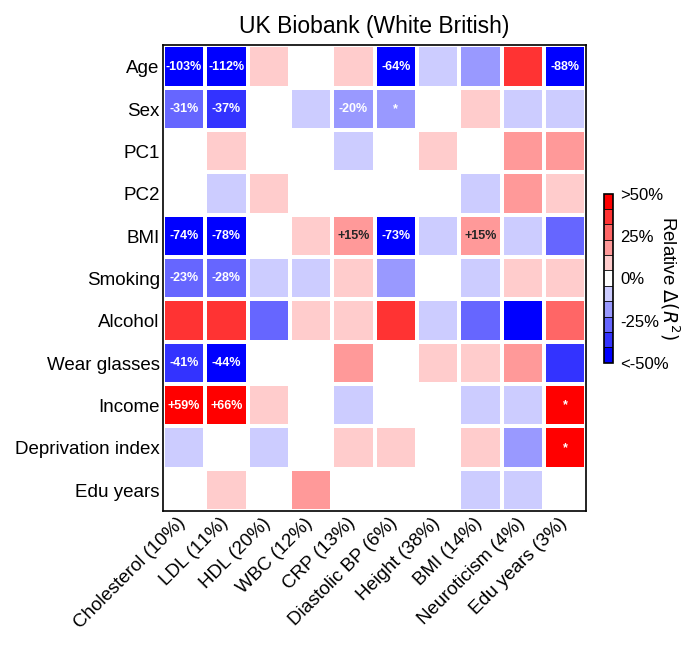

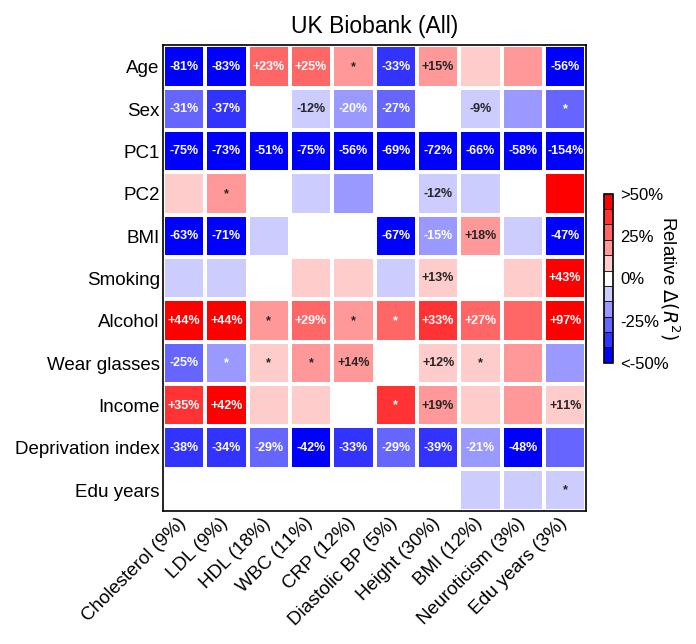

In [6]:
for i, group in enumerate(["white", "all"]):
    fig, ax = plot_wrapper(group=group, trait_list=main_trait_list)
    if group == "white":
        ax.set_title("UK Biobank (White British)", fontsize=11)
    elif group == "all":
        ax.set_title("UK Biobank (All)", fontsize=11)
    else:
        raise NotImplementedError

    fig.savefig(f"results/main_heatmap.{group}.pdf", bbox_inches="tight")
    fig.show()

In [7]:
all_trait_list = pd.read_excel("results/trait_info.xlsx")["id"].values

df_tmp = pd.DataFrame({"id": all_trait_list})
df_tmp["name"] = df_tmp["id"].apply(lambda x: trait_map[x])

all_trait_list = df_tmp.sort_values("name")["id"].values

In [9]:
len(all_trait_list)

84

N=48 with number: p < 0.05 / 924; N=101 with *: p < 0.05 / 11
PGSs with at least one significant covariate: 29
N=370 with number: p < 0.05 / 924; N=497 with *: p < 0.05 / 11
PGSs with at least one significant covariate: 83


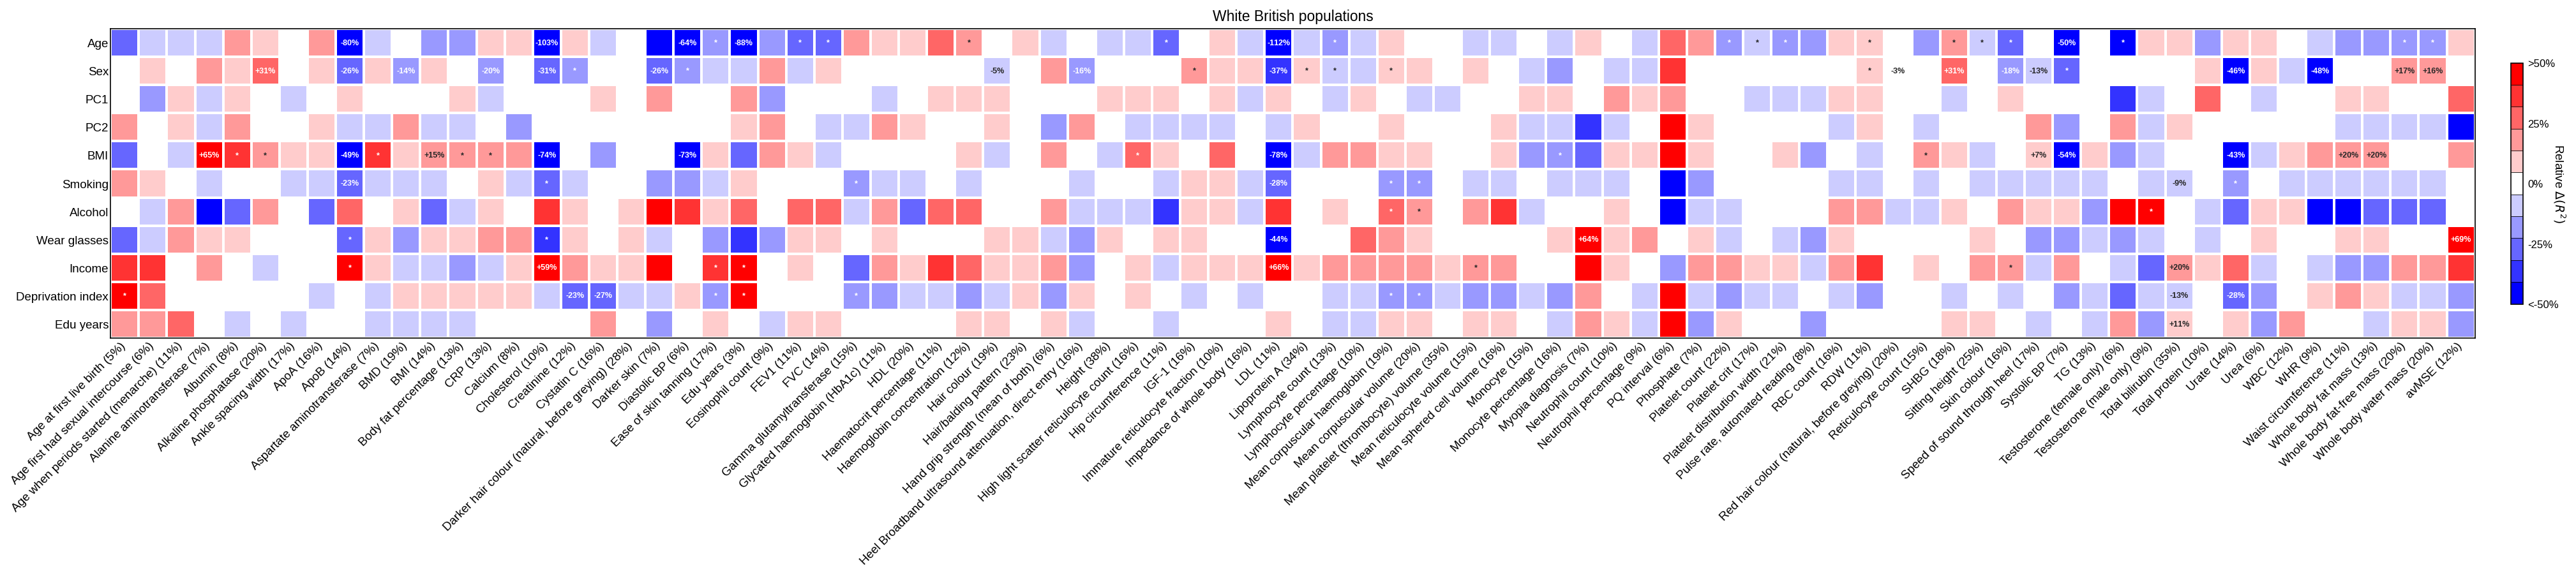

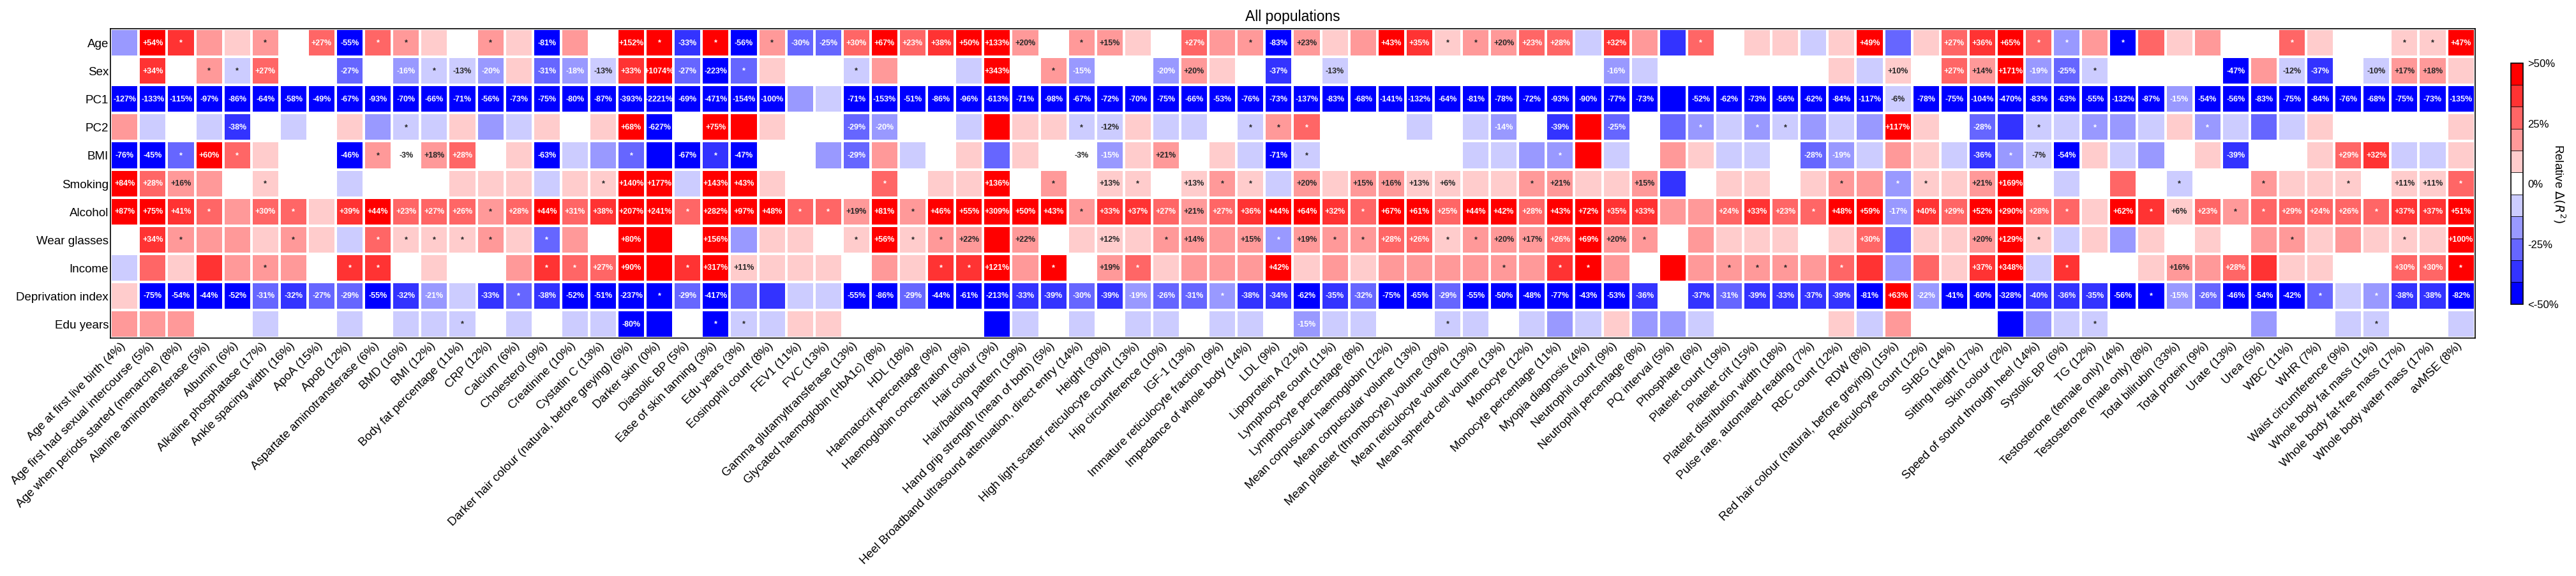

In [8]:
for group in ["white", "all"]:

    fig, ax = plot_wrapper(
        group=group, trait_list=all_trait_list, cbar_pad=0.015, cbar_fraction=0.005
    )
    if group == "white":
        ax.set_title("White British populations", fontsize=11)
    elif group == "all":
        ax.set_title("All populations", fontsize=11)
    else:
        raise NotImplementedError
    fig.savefig(f"results/all_heatmap.{group}.pdf", bbox_inches="tight")
    fig.show()